In [1]:
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
# import dask
# import dask.distributed
# import ncar_jobqueue
import esmlab
import esmlab_regrid
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from netCDF4 import default_fillvals
import pop_tools 

import config

import warnings
from datetime import date, datetime, timezone

### This notebook interpolates GLODAP data onto the same vertical levels as POP
### It leaves lateral grid the same (360 x 180)
### USE analysis2 environment!
### Prep work
set up directory with original and destination grid files in it

In [2]:
USER = os.environ['USER']
gridfile_directory = esmlab.config.set({'regrid.gridfile-directory': f'/glade/work/{USER}/esmlab-regrid'})
esmlab.config.get('regrid.gridfile-directory')

'/glade/work/kristenk/esmlab-regrid'

In [3]:
method = 'conservative'
src_grid = 'latlon_1x1_180W'
dst_grid = 'POP_gx1v7'
ltripole = False

regrid_operator = esmlab_regrid.regridder(name_grid_src=src_grid, 
                                          name_grid_dst=dst_grid, 
                                          method=method, overwrite_existing=False)

/glade/work/kristenk/esmlab-regrid
/glade/work/kristenk/esmlab-regrid


In [4]:
ds_dst = pop_tools.get_grid(grid_name=dst_grid)
ds_dst

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 2.339e+06 2.339e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    TAREA        (nlat, nlon) float64 1.39e+13 1.39e+13 ... 7.431e+12 7.432e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0

### Define a dictionary to translate variable names from GLODAP to POP and set up file paths

### Use the function to get GLODAP data

In [5]:
ds_glodap = xr.open_mfdataset('/glade/work/kristenk/GLODAPv2_regridded/*.nc',decode_times=False,decode_coords=False)
ds_glodap = ds_glodap.rename({'depth_surface': 'depth'})
ds_glodap

<xarray.Dataset>
Dimensions:                 (depth: 33, lat: 180, lon: 360)
Coordinates:
  * lon                     (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * lat                     (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * depth                   (depth) float64 0.0 10.0 20.0 ... 5e+03 5.5e+03
Data variables:
    Cant                    (depth, lat, lon) float32 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    CantInput_mean          (depth, lat, lon) float32 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    NO3                     (depth, lat, lon) float32 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    NO3Input_mean           (depth, lat, lon) float32 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    OmegaA                  (depth, lat, lon) float32 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    OmegaAInput_mean        (depth, lat, lon) float32 dask.array<shape=(33, 180, 360), chunksiz

In [6]:
varlist = ['TAlk','TAlkInput_mean','NO3','NO3Input_mean','salinity','salinityInput_mean']

In [7]:
ds_glodap.depth.data = ds_glodap.depth.data * 1e2
ds_glodap.depth.attrs['units'] = 'cm'

In [9]:
ds_dst.z_t

<xarray.DataArray 'z_t' (z_t: 60)>
array([5.000000e+02, 1.500000e+03, 2.500000e+03, 3.500000e+03, 4.500000e+03,
       5.500000e+03, 6.500000e+03, 7.500000e+03, 8.500000e+03, 9.500000e+03,
       1.050000e+04, 1.150000e+04, 1.250000e+04, 1.350000e+04, 1.450000e+04,
       1.550000e+04, 1.650984e+04, 1.754790e+04, 1.862913e+04, 1.976603e+04,
       2.097114e+04, 2.225783e+04, 2.364088e+04, 2.513702e+04, 2.676542e+04,
       2.854837e+04, 3.051192e+04, 3.268680e+04, 3.510935e+04, 3.782276e+04,
       4.087847e+04, 4.433777e+04, 4.827367e+04, 5.277280e+04, 5.793729e+04,
       6.388626e+04, 7.075633e+04, 7.870025e+04, 8.788252e+04, 9.847059e+04,
       1.106204e+05, 1.244567e+05, 1.400497e+05, 1.573946e+05, 1.764003e+05,
       1.968944e+05, 2.186457e+05, 2.413972e+05, 2.649001e+05, 2.889385e+05,
       3.133405e+05, 3.379794e+05, 3.627670e+05, 3.876452e+05, 4.125768e+05,
       4.375393e+05, 4.625190e+05, 4.875083e+05, 5.125028e+05, 5.375000e+05])
Coordinates:
  * z_t      (z_t) float64 

### Regrid vertically

In [10]:
dso_vert = xr.Dataset()

dim = 'depth'
new_coord = ds_dst.z_t
for v in varlist:
    da = ds_glodap[v]
    dso_vert[v] = da.interp(coords={dim: new_coord},
                                method='linear',
                                assume_sorted=True,
                                kwargs={'bounds_error': False})
    dso_vert[v] = xr.where(np.isclose(dso_vert[v], 0., atol=1e-10), 0., 
                               dso_vert[v])
    dso_vert[v].attrs = ds_glodap[v].attrs
    
dso_vert = dso_vert.drop([dim])
dso_vert

<xarray.Dataset>
Dimensions:             (lat: 180, lon: 360, z_t: 60)
Coordinates:
  * lon                 (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * z_t                 (z_t) float64 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Data variables:
    TAlk                (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
    TAlkInput_mean      (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
    NO3                 (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
    NO3Input_mean       (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
    salinity            (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
    salinityInput_mean  (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>

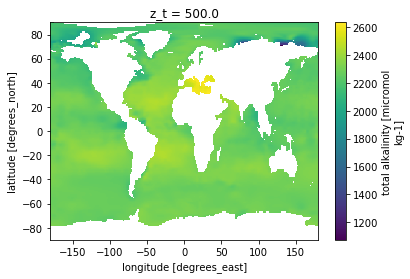

In [12]:
dso_vert.TAlk.isel(z_t=0).plot()

### Get the dataset ready to write out

In [13]:
#dso = dso_smooth.copy()
dso = dso_vert.copy()
for v in dso.variables:
    dso[v].encoding['_FillValue'] = default_fillvals['f4']
    dso[v].encoding['dtype'] = np.float32
    
for v in dso.variables:
    if '_FillValue' not in dso[v].encoding:
        dso[v].encoding['_FillValue'] = None
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
dso.attrs['history'] = f'created by kristen krumhardt on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
dso

<xarray.Dataset>
Dimensions:             (lat: 180, lon: 360, z_t: 60)
Coordinates:
  * lon                 (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * z_t                 (z_t) float64 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Data variables:
    TAlk                (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
    TAlkInput_mean      (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
    NO3                 (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
    NO3Input_mean       (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
    salinity            (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
    salinityInput_mean  (z_t, lat, lon) float32 dask.array<shape=(60, 180, 360), chunksize=(60, 180, 360)>
Attributes:
    hist

In [14]:
file_out = '/glade/work/kristenk/GLODAPv2_regridded/glodap_pop_vert_levels/GLODAPv2_POP_z_t.nc'
dso.to_netcdf(file_out)